# Are Relations Relevant in CNNs? *A Study Based on a Facial Dataset*

## Testing Baseline FCN *(20 Epochs - 15 Layers)*

### Imports, Seed, GPU integration

In [1]:
import numpy as np
import random
import tensorflow as tf

In [2]:
# Seeds for better reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


### Data preparation

In [5]:
test_path = '../../../picasso_dataset/FFA-data/shifted/test'

In [6]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['no_face', 'face'], batch_size=10, shuffle=False)

Found 3000 images belonging to 2 classes.


In [7]:
assert test_batches.n == 3000
assert test_batches.num_classes == 2

### Loading the trained FCN

In [8]:
filename='../models/FCN-FFA-20E-16L-03.h5'
loaded_model = load_model(filename)

### Accuracy and loss of the trained model

In [9]:
scores = loaded_model.evaluate(test_batches, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Loss: %.2f%%" % (scores[0]*100))

300/300 - 7s - loss: 7.2707e-04 - accuracy: 0.9993
Accuracy: 99.93%
Loss: 0.07%


### Testing the FCN

In [10]:
predictions = loaded_model.predict(x=test_batches, steps=len(test_batches), verbose=0)

### Index of wrongly predicted pictures

In [11]:
y_true=test_batches.classes
y_pred=np.argmax(predictions, axis=-1)
cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

In [12]:
face_but_predicted_no_face=[]
no_face_but_predicted_face=[]

for i in range(len(predictions)):
        if y_true[i] != y_pred[i]:
            if y_true[i] == 1:
                face_but_predicted_no_face.append(i+8001-1500) #Index of file on disk
            else:
                no_face_but_predicted_face.append(i+8001) #Index of file on disk

print("Data from class 'face', that was wrongly predicted as 'no-face' [", len(face_but_predicted_no_face), "] :")
print(face_but_predicted_no_face)
print("----------------------------------------------------------------------------------------------")
print("Data from class 'no-face', that was wrongly predicted as 'face' [", len(no_face_but_predicted_face), "] :")
print(no_face_but_predicted_face)

Data from class 'face', that was wrongly predicted as 'no-face' [ 2 ] :
[9014, 9047]
----------------------------------------------------------------------------------------------
Data from class 'no-face', that was wrongly predicted as 'face' [ 0 ] :
[]


### Confusion matrix

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
test_batches.class_indices

{'no_face': 0, 'face': 1}

Confusion matrix, without normalization
[[1500    0]
 [   2 1498]]


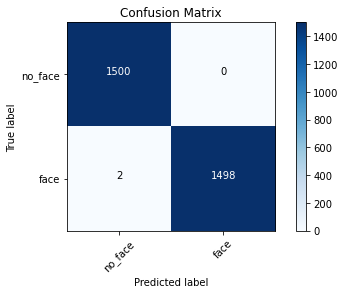

In [15]:
cm_plot_labels = ['no_face','face']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')